# **Subreddits Classification and Sentiments Analysis Project**


-------------

## Introduction:

In this project you will analyze data from the reddit.com, one of the most popular online social platforms, and apply some of the techniques covered in the course.
In Reddit, posts are organized into user-created boards called "subreddits", which cover a variety of topics like news, science, movies, video games, music, etc. Users can up-vote or down-vote a post, as well as commenting on a post.
In this project you will analyze a sample of posts (without their comments) from a small subset of very active subreddits. The key tasks in this project are:
a. Exploratory data analysis.
b. Automatically classifying posts to their subreddit. c. Analyzing the sentiments in reddit post titles.
Following is information of the deliverables and marking scheme, academic integrity, and the submission process. Then, we provide detailed explanation for each of the parts on the project.

-------------


## Part 1: Data Loading

### (a) Load the provided dataset (reddit_data.json)

In [0]:
import pandas as pd

In [0]:
data_all = pd.read_json("reddit_data.zip", orient='records', lines=True)
data_all = data_all[["id", "author", "created_utc", "subreddit", "title", "num_comments", "score", "selftext", "url"]]

In [0]:
data_all.head()

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url
0,abcupx,WithGravy,1546300839,gaming,What are some game games to enjoy on a low-end...,31,3,Got a new laptop and want to enjoy some games ...,https://www.reddit.com/r/gaming/comments/abcup...
1,abcuz2,mikebeingfrank,1546300881,pics,"In 1964, an average wage worker had to clock 8...",4,5,,https://i.redd.it/j6rqqthwcp721.jpg
2,abcv1a,[deleted],1546300892,worldnews,"India: Chinese woman, 25, on solo trip to Khaj...",13,23,,https://timesofindia.indiatimes.com/city/agra/...
3,abcv5v,Lucious-Lyon,1546300914,AskReddit,[Serious] American Liberals of Reddit: Without...,76,0,[removed],https://www.reddit.com/r/AskReddit/comments/ab...
4,abcv7f,sandollars,1546300923,worldnews,"According to the Fiji Government, the Australi...",21,13,,http://fijisun.com.fj/2019/01/01/vuniwaqa-prak...


### (b)	Generate your unique subset of the data

**Make sure you update unique_string with your email address**

In [0]:
# DO NOT CHANGE THE FUNCTION BELOW
def getMySubreddits(data, my_str):
    assert my_str != "", "You must fill in your unique string"
    import random
    subreddits = sorted(data["subreddit"].unique().tolist())
    rng = random.Random(my_str)
    return rng.sample(subreddits, 4)

In [0]:
# Fill in your UofT email in the variable unique_string below
unique_string = "yuchao.wu@mail.utoronto.ca" 
my_subreddits = getMySubreddits(data_all, unique_string)
print("My subreddits:", my_subreddits)

My subreddits: ['Music', 'AdviceAnimals', 'Android', 'leagueoflegends']


In [0]:
data = data_all[data_all["subreddit"].isin(my_subreddits)]

## Part 2: Exploratory Data Analysis 

### Imbalanced Data
- From the countplot below, the four subreddits that I will be analyzing are imbalanced. Music subreddit has the highest number of posts compared to other subreddits. 
- There are several ways of dealing with a imbalanced dataset. One approach could be to undersample the majority class and oversample the minority class. Another approach could be to use precision, recall or F1-score as performance metrics instead of mere accuracy.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


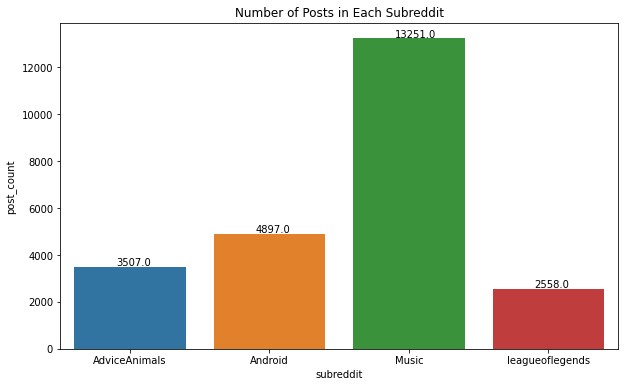

In [0]:
plot = data.groupby('subreddit')['id'].count().reset_index().rename(columns={'id':'post_count'})
plt.figure(figsize=(10, 6))
plt.title('Number of Posts in Each Subreddit')
ax=sns.barplot(x="subreddit", y="post_count", data=plot)
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.3, p.get_height()+50))
plt.show()

### Column id
- From simple exploration, id is a unique identifier for each post. Therefore it is not useful for classification.

In [0]:
data.id.nunique()

24213

In [0]:
len(data.id)

24213

### Column author
- First of all, by looking at the top 20 productive authors' number of posts by subreddit, what can be observed is that the top productive users always only post on one subreddit rather than post actively in all four subreddits. They are very concentrated on their interests/specialty. Thus author could be a useful predictor.
- However, there are 12718 unqiue authors in all four subreddits. Thus label encoding can't be done to all 12718 unique authors.

In [0]:
data.author.nunique()

12718

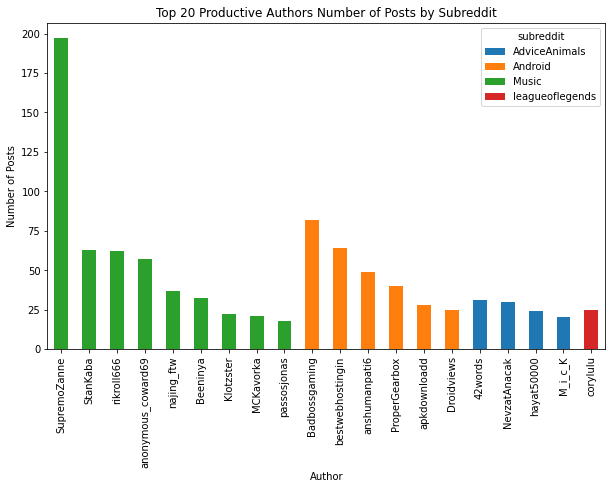

In [0]:
# Plot the number of plots for each author based on the subrredits
plot = data[data['author']!='[deleted]'].groupby(['subreddit', 'author']).size().reset_index().\
                                sort_values(by=0,ascending=False).head(20).\
                                pivot(columns='subreddit', index='author', values=0)

plot = plot.sort_values(by=['Music','Android','AdviceAnimals','leagueoflegends'],ascending=[False,False,False,False])
ax = plot.plot(kind='bar', stacked=True,figsize=(10, 6))
ax.set(xlabel='Author', ylabel='Number of Posts')
plt.title('Top 20 Productive Authors Number of Posts by Subreddit')
plt.show()

- What could be predictive of subreddit instead is to identify the productive users in each of the four subreddits and create an indicator for each subreddit of whether an author is a productive user or not. Then for a post which we don't know its subreddit, if it's posted by a productive user in a specific subreddit, it very likely belongs to that subreddit. 
- The definition of a productive user in a subreddit is that he/she has posted 5 times in the subreddit from January 2019.
- What needs to be noted here is that, such feature engineering can only be done after train and test split. Because the features engineered are based on the target variable. If it is done before train and test split, there might be target leakage issue.

In [0]:
subreddit_author = data.groupby(['author','subreddit'])['id'].count().reset_index().\
                        rename(columns={'id':'subreddit_post_count'}).sort_values(by\
                        =['subreddit','subreddit_post_count'],ascending=[False,False])
post_count = data.groupby('author')['id'].count().reset_index().\
                        rename(columns={'id':'post_count'}).sort_values(by='post_count',ascending=False)
subreddit_author = pd.merge(subreddit_author,post_count,on='author',how='left')
subreddit_author = subreddit_author[subreddit_author['author']!='[deleted]']
subreddit_author['subreddict_pcg']=subreddit_author['subreddit_post_count']/subreddit_author['post_count']
subreddit_author

,author,subreddit,subreddit_post_count,post_count,subreddict_pcg
1,corylulu,leagueoflegends,25,25,1.0
2,despicable404,leagueoflegends,8,8,1.0
3,DvaProBro,leagueoflegends,7,7,1.0
4,KittykatRengar,leagueoflegends,6,6,1.0
5,Regrup,leagueoflegends,6,6,1.0
...,...,...,...,...,...
12771,zman1175,AdviceAnimals,1,1,1.0
12772,zo0bie,AdviceAnimals,1,1,1.0
12773,zordie360,AdviceAnimals,1,1,1.0
12774,zortor,AdviceAnimals,1,1,1.0


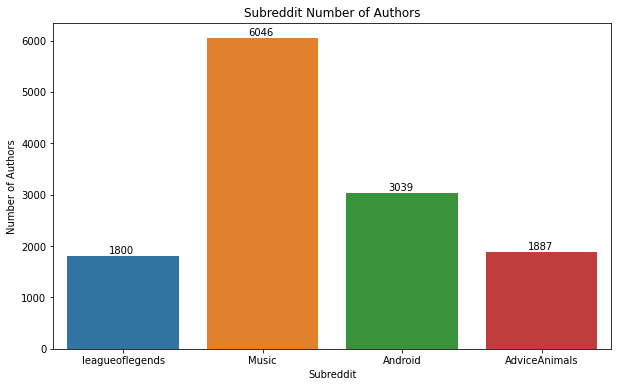

In [0]:
plt.figure(figsize=(10, 6))
plt.title('Subreddit Number of Authors')
ax = sns.countplot(x="subreddit",data=subreddit_author)
ax.set(xlabel='Subreddit', ylabel='Number of Authors')
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.3, p.get_height()+50))
plt.show()

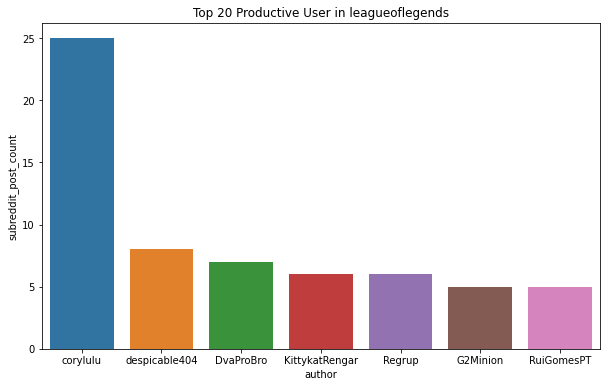

In [0]:
leagueoflegends_author = subreddit_author[subreddit_author['subreddit']=='leagueoflegends']
plot = leagueoflegends_author[leagueoflegends_author['subreddit_post_count']>=5]
plt.figure(figsize=(10, 6))
plt.title('Top 20 Productive User in leagueoflegends')
sns.barplot(x="author", y="subreddit_post_count", data=plot)

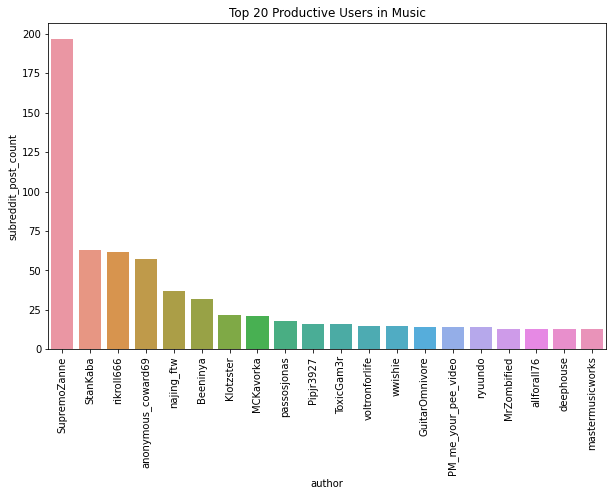

In [0]:
music_author = subreddit_author[subreddit_author['subreddit']=='Music']
plot = music_author[music_author['subreddit_post_count']>=5]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.title('Top 20 Productive Users in Music')
sns.barplot(x="author", y="subreddit_post_count", data=plot.head(20))

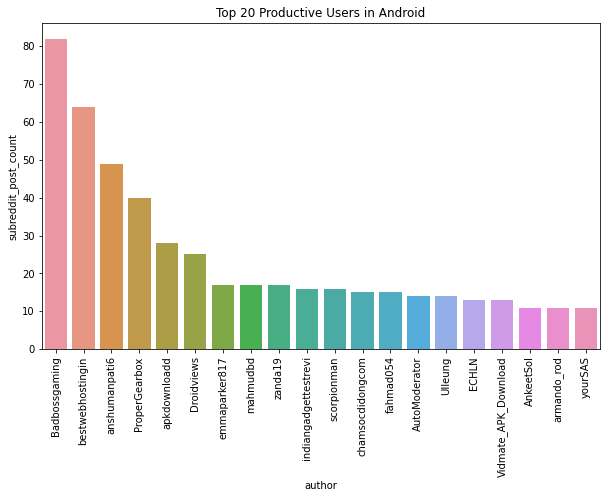

In [0]:
android_author = subreddit_author[subreddit_author['subreddit']=='Android']
plot = android_author[android_author['subreddit_post_count']>=5]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.title('Top 20 Productive Users in Android')
sns.barplot(x="author", y="subreddit_post_count", data=plot.head(20))

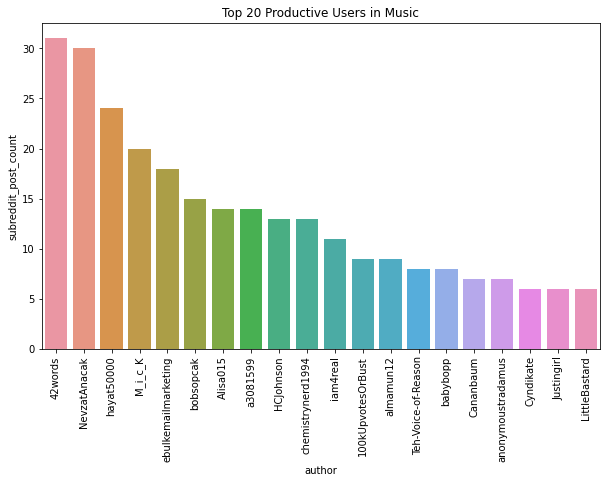

In [0]:
adviceanimals_author = subreddit_author[subreddit_author['subreddit']=='AdviceAnimals']
plot = adviceanimals_author[adviceanimals_author['subreddit_post_count']>=5]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.title('Top 20 Productive Users in Music')
sns.barplot(x="author", y="subreddit_post_count", data=plot.head(20))

### Column created_utc
- From simple exploration, created_utc, UTC timestamp of post, has 24091 unique values when there are in total 24213 entries. Since the column definition is not so clear and logically time of a post can hardly reveal any useful information on its subreddit, it will not be included in further analysis. 

In [0]:
data.created_utc.nunique()

24091

### Column title

- Before diving into title text, feature extraction and vectorization, our first step should be clean the data in 
order to obtain better features. We will achieve this by data pre-processing. Note that only words should be left for further machine learning step to improve the qulaity of the data training set. Any special characters (e.g., *,$) will be removed and not included in our top words anlaysis.

In [0]:
# Lower case
data['title']  = data['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [0]:
# remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['title'] = data['title'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText
data['title'] = preprocess(data['title'])

- As respect for title word count, posts in AdviceAnimals seem to have on average a lower title word count than the posts in other subreddits. Posts in Music subreddit have slighly higher title word count and slightly lower standard deviation in title word count compared to posts in other subreddit. This generated feature could be a predictive feature.

In [0]:
data['word_count'] = data['title'].apply(lambda x: len(str(x).split(" ")))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8bb1b2ae80>,
      dtype=object)

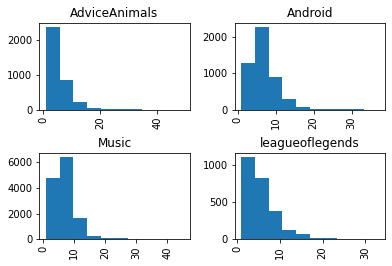

In [0]:
data['word_count'].hist(by=data['subreddit'])

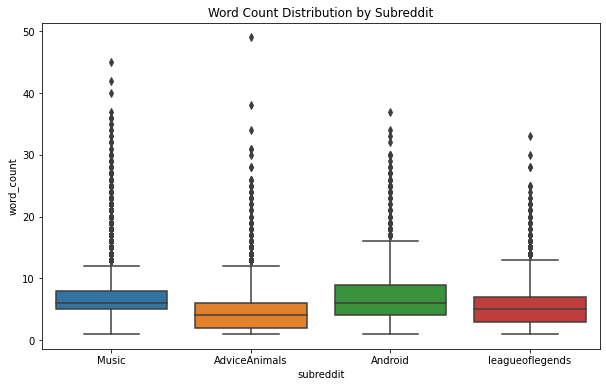

In [0]:
plt.figure(figsize=(10, 6))
plt.title('Word Count Distribution by Subreddit')
sns.boxplot(x="subreddit", y="word_count", data=data)

- The point of doing bigrams for titles in each of the four subreddits is to see whether the top bigrams are clearly different for different subreddits. And it is clearly the case. Therefore, there's confidence that after vectorization of the title column. It should be predictive of the post's subreddit.

In [0]:
# define top n words and top n bigram
import sklearn
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

rock 2117
music 1296
android 1201
new 1143
pop 1024
song 879
2019 756
hop 635
hip 621
like 604
video 571
google 558
alternative 543
indie 531
phone 531
rap 480
help 460
app 449
best 441
love 417


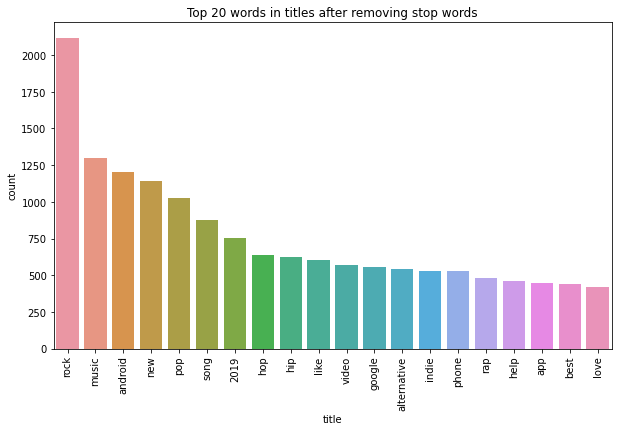

In [0]:
# top 20 words in all titles
common_words = get_top_n_words(data['title'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['title' , 'count'])
plot = df2.groupby('title').sum()['count'].reset_index().sort_values(by='count',ascending=False)
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.title('Top 20 words in titles after removing stop words')
sns.barplot(x="title", y="count", data=plot)

- Next, I can deep dive in each subreddit and see what top words or n-grams. We can choose bigram instead of words to get more information.

hip hop 608
alternative rock 197
music video 191
indie rock 160
new wave 122
pop rock 97
post hardcore 97
post punk 89
hop rap 85
official music 79
indie pop 74
alt rock 68
official video 67
folk rock 66
punk rock 61
classic rock 58
psychedelic rock 55
hard rock 55
new song 53
new music 53


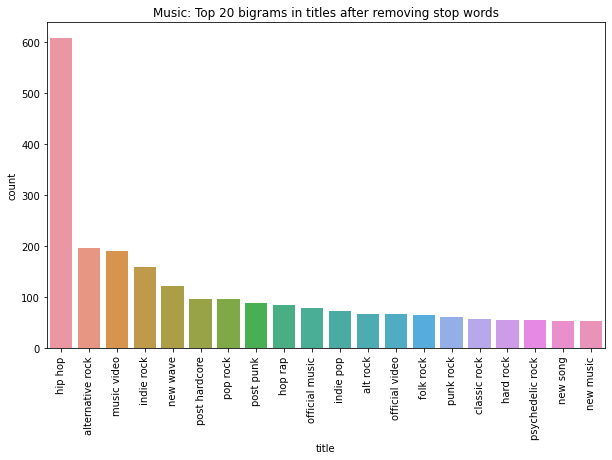

In [0]:
# top 20 bigram in Music subreddit
common_words = get_top_n_bigram(data[data['subreddit']=='Music']['title'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['title' , 'count'])
plot = df2.groupby('title').sum()['count'].reset_index().sort_values(by='count',ascending=False)
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.title('Music: Top 20 bigrams in titles after removing stop words')
sns.barplot(x="title", y="count", data=plot)

new year 16
feel like 9
government shutdown 9
حالات واتس 9
polar vortex 9
years ago 8
wild zoo 8
animals names 8
year old 8
المهدى المنتظر 7
dog loves 7
loves baby 7
zoo animals 7
ve seen 7
time year 6
واتس اب 6
dog training 5
feel bad 5
want watch 5
star wars 5


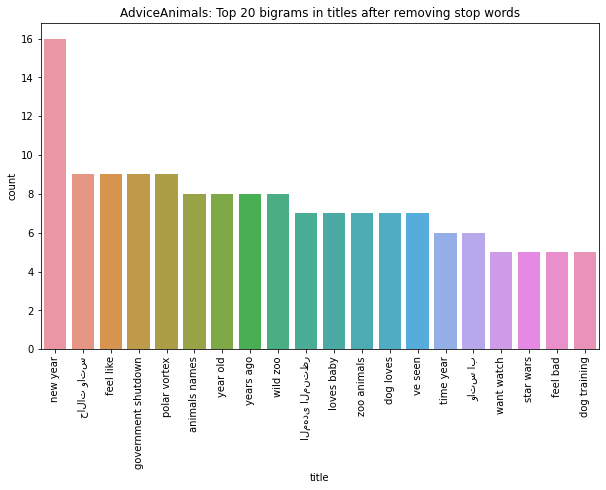

In [0]:
common_words = get_top_n_bigram(data[data['subreddit']=='AdviceAnimals']['title'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['title' , 'count'])
plot = df2.groupby('title').sum()['count'].reset_index().sort_values(by='count',ascending=False)
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.title('AdviceAnimals: Top 20 bigrams in titles after removing stop words')
sns.barplot(x="title", y="count", data=plot)

samsung galaxy 93
android phone 82
android pie 76
galaxy s10 75
stock rom 61
flash file 60
firmware download 60
download stock 60
google play 53
google pixel 51
google assistant 51
android app 49
file motorola 47
motorola moto 47
play store 43
android gameplay 38
galaxy s9 36
redmi note 36
android apps 33
oneplus 6t 33


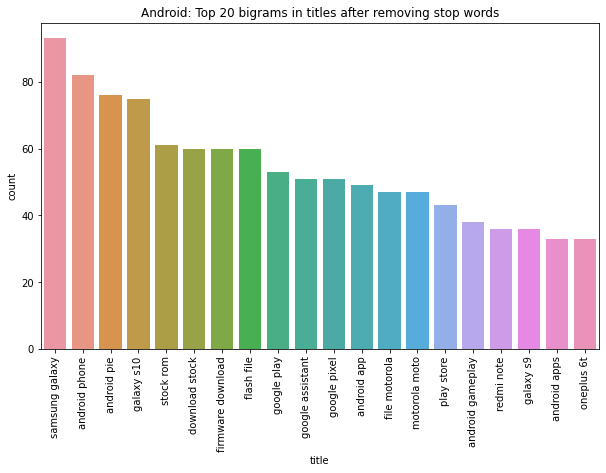

In [0]:
common_words = get_top_n_bigram(data[data['subreddit']=='Android']['title'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['title' , 'count'])
plot = df2.groupby('title').sum()['count'].reset_index().sort_values(by='count',ascending=False)
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.title('Android: Top 20 bigrams in titles after removing stop words')
sns.barplot(x="title", y="count", data=plot)

league legends 56
new ranked 16
post match 16
nexus blitz 15
twitch rivals 15
match discussion 15
blood moon 13
2019 spring 13
spring week 13
week post 12
riot games 11
solo queue 10
lee sin 10
champ select 10
lunar revel 10
new season 9
season start 9
new champion 8
ranked game 8
feel like 8


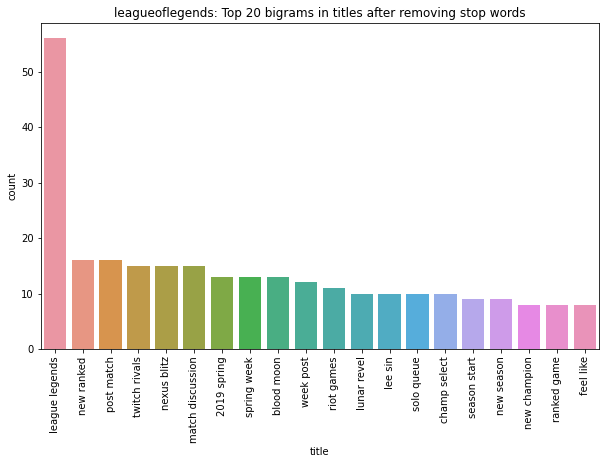

In [0]:

common_words = get_top_n_bigram(data[data['subreddit']=='leagueoflegends']['title'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['title' , 'count'])
plot = df2.groupby('title').sum()['count'].reset_index().sort_values(by='count',ascending=False)
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.title('leagueoflegends: Top 20 bigrams in titles after removing stop words')
sns.barplot(x="title", y="count", data=plot)

### Column num_comments

- By looking at distribution of number of comments by each subreddit below, I found that as Music has the most posts, most posts don't have comments more than 2, similar to Android. Posts in leagueoflegends and AdviceAnimals on average have higher number of comments. Thus in the histogram below, for better visualization of trends for comparison purpose, I only visualized posts with lower than 100 comments. 

In [0]:
data['num_comments'].groupby(data['subreddit']).describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
AdviceAnimals,3507.0,35.090106,226.552769,0.0,0.0,1.0,6.0,4960.0
Android,4897.0,18.728609,91.070255,0.0,0.0,1.0,2.0,2785.0
Music,13251.0,6.197721,104.651133,1.0,1.0,1.0,2.0,6442.0
leagueoflegends,2558.0,20.020328,83.360789,1.0,1.0,4.0,10.0,1469.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8bb1a26048>,
      dtype=object)

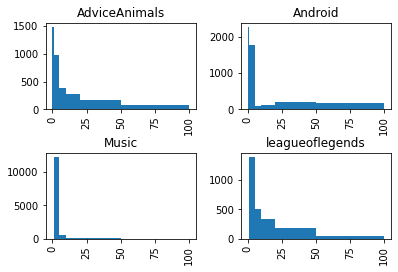

In [0]:
data['num_comments'].hist(by=data['subreddit'],bins=[0,1,5,10,20,50,100])

### ColumnScore

- It is obvious from the overall distribution of score that AdviceAnimals subreddit has higher scores than other subreddits.

In [0]:
data['score'].groupby(data['subreddit']).describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
AdviceAnimals,3507.0,782.689193,4713.666160,0.0,1.0,3.0,34.0,78454.0
Android,4897.0,71.070247,572.658665,0.0,1.0,1.0,1.0,23479.0
Music,13251.0,57.846049,1308.550877,0.0,1.0,1.0,2.0,90279.0
leagueoflegends,2558.0,60.515637,417.034033,0.0,0.0,1.0,2.0,11253.0


- By looking at the histograms, AdiveAnimals has more posts with high scores, followed by league of legends.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8bb10a3630>,
      dtype=object)

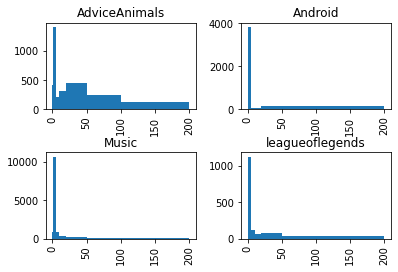

In [0]:
data['score'].hist(by=data['subreddit'],bins=[0,1,5,10,20,50,100,200])

- From correlation analysis results in the table below, number of comments is highly positively correlated with score, which makes sense as popular views of a post would have more comments and higher scores. As a result, column score can be removed from further classification modelling.

In [0]:
data.groupby('subreddit')[['num_comments','score']].corr()

num_comments     score
subreddit                                           
AdviceAnimals   num_comments      1.000000  0.855118
                score             0.855118  1.000000
Android         num_comments      1.000000  0.828338
                score             0.828338  1.000000
Music           num_comments      1.000000  0.853356
                score             0.853356  1.000000
leagueoflegends num_comments      1.000000  0.719506
                score             0.719506  1.000000

- Average score per comment is generated, and there seems to be differentiations among the four subreddits.

In [0]:
import numpy as np
data['average_score_per_comment']= data['score']/data['num_comments']
data['average_score_per_comment'] = data['average_score_per_comment'].replace([np.inf, -np.inf], np.nan)
data['average_score_per_comment'] = data['average_score_per_comment'].fillna(0)
data.groupby('subreddit')['average_score_per_comment'].mean().reset_index()

,subreddit,average_score_per_comment
0,AdviceAnimals,6.528599
1,Android,0.925719
2,Music,1.676032
3,leagueoflegends,1.038067


### Column selftext
- Since this column is an optional column with a lot of entries being deleted or removed, it is not a good independent variable for subreddit classification and thus will be remove in further classification.

### Column url
- By exploring the top 50 entries for url for the different subreddits, there are some obvious patterns such as urls for posts in music are usually youtube links, whereas urls for posts in AdviceAnimals are usually linked to jpg files.

In [0]:
from urllib.parse import urlparse

In [0]:
pd.set_option('display.max_colwidth', -1)
# data[data['subreddit']=='Music'][['url']].head(50)
# data[data['subreddit']=='Android'][['url']].head(50)
# data[data['subreddit']=='AdviceAnimals'][['url']].head(50)
# data[data['subreddit']=='leagueoflegends'][['url']].head(50)

- Lower case for all alphabets in url makes it easier for later generation of features.

In [0]:
data.loc[:,'url'] = [entry.lower() for entry in data['url']]

- Different indicators are generated to indicate whether the url for a post contains 'music','youtube','jpg'... or not. From the countplots below, it is very likely that these indicators will be strong predictors for subreddit. Since url containing 'music' or 'youtube' is very likely from a Music subreddit post, whereas url containing jpg is very likely from a AdviceAnimals subreddit post.

In [0]:
data.loc[data['url'].str.contains('music'), 'url_contains_music'] = 1
data.loc[~data['url'].str.contains('music'), 'url_contains_music'] = 0

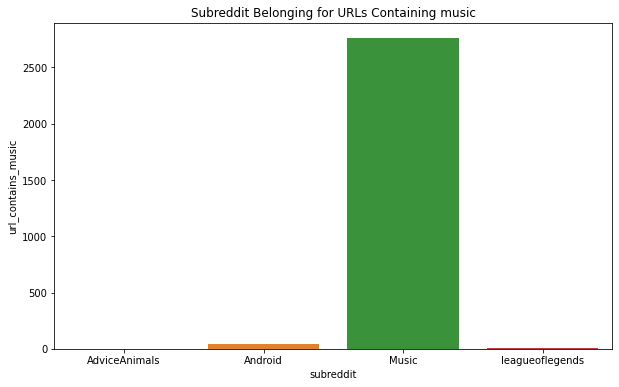

In [0]:
plot = data.groupby('subreddit')['url_contains_music'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.title('Subreddit Belonging for URLs Containing music')
sns.barplot(x="subreddit", y="url_contains_music", data=plot)

In [0]:
data.loc[data['url'].str.contains('android'), 'url_contains_android'] = 1
data.loc[~data['url'].str.contains('android'), 'url_contains_android'] = 0

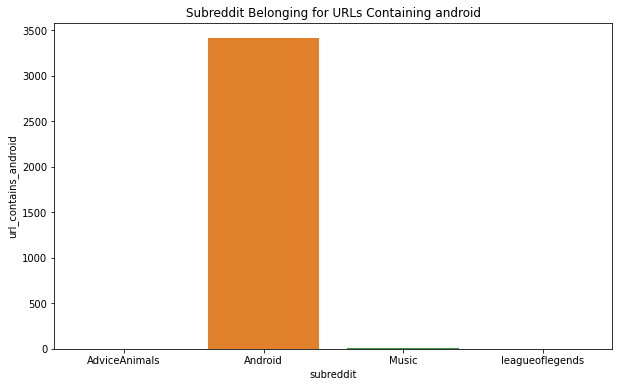

In [0]:
plot = data.groupby('subreddit')['url_contains_android'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.title('Subreddit Belonging for URLs Containing android')
sns.barplot(x="subreddit", y="url_contains_android", data=plot)

In [0]:
data.loc[data['url'].str.contains('adviceanimals'), 'url_contains_adviceanimals'] = 1
data.loc[~data['url'].str.contains('adviceanimals'), 'url_contains_adviceanimals'] = 0

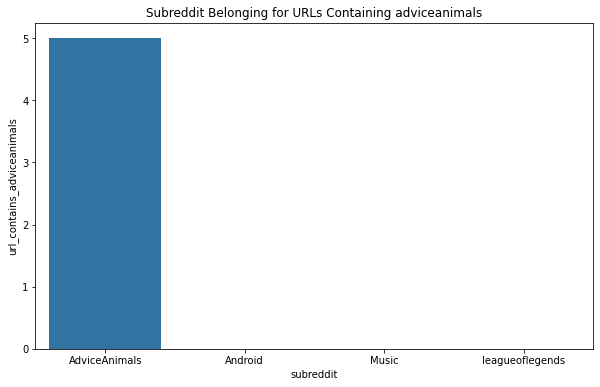

In [0]:
plot = data.groupby('subreddit')['url_contains_adviceanimals'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.title('Subreddit Belonging for URLs Containing adviceanimals')
sns.barplot(x="subreddit", y="url_contains_adviceanimals", data=plot)

In [0]:
data.loc[data['url'].str.contains('leagueoflegends'), 'url_contains_leagueoflegends'] = 1
data.loc[~data['url'].str.contains('leagueoflegends'), 'url_contains_leagueoflegends'] = 0

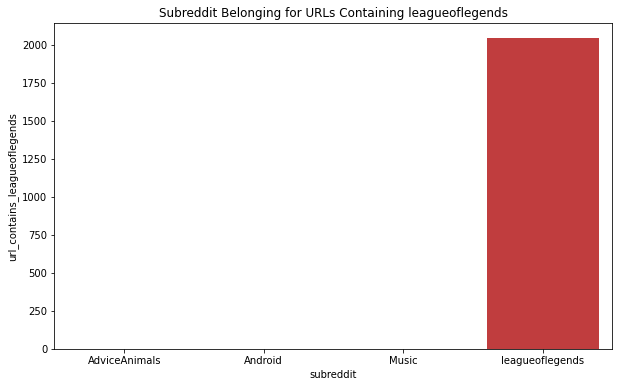

In [0]:
plot = data.groupby('subreddit')['url_contains_leagueoflegends'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.title('Subreddit Belonging for URLs Containing leagueoflegends')
sns.barplot(x="subreddit", y="url_contains_leagueoflegends", data=plot)

In [0]:
data.loc[data['url'].str.contains('jpg'), 'url_contains_jpg'] = 1
data.loc[~data['url'].str.contains('jpg'), 'url_contains_jpg'] = 0

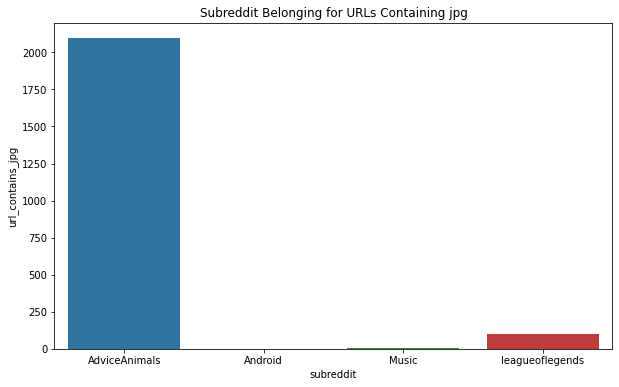

In [0]:
plot = data.groupby('subreddit')['url_contains_jpg'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.title('Subreddit Belonging for URLs Containing jpg')
sns.barplot(x="subreddit", y="url_contains_jpg", data=plot)

In [0]:
data.loc[data['url'].str.contains('youtube|youtu.be'), 'url_contains_youtube'] = 1
data.loc[~data['url'].str.contains('youtube|youtu.be'), 'url_contains_youtube'] = 0

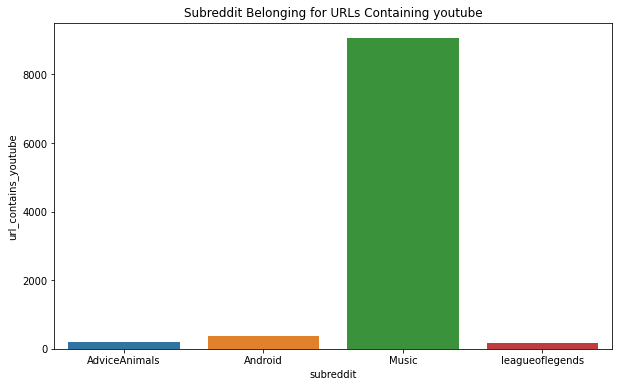

In [0]:
plot = data.groupby('subreddit')['url_contains_youtube'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.title('Subreddit Belonging for URLs Containing youtube')
sns.barplot(x="subreddit", y="url_contains_youtube", data=plot)

In [0]:
data.loc[data['url'].str.contains('png'), 'url_contains_png'] = 1
data.loc[~data['url'].str.contains('png'), 'url_contains_png'] = 0

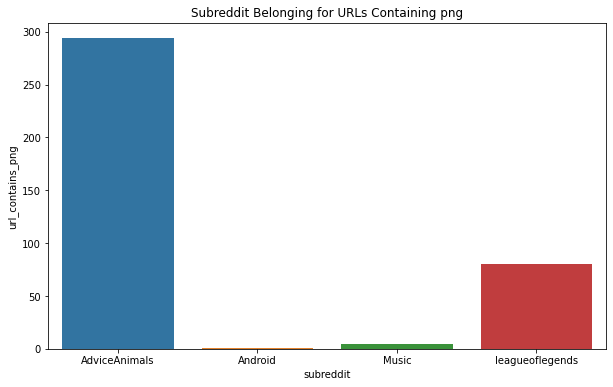

In [0]:
plot = data.groupby('subreddit')['url_contains_png'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.title('Subreddit Belonging for URLs Containing png')
sns.barplot(x="subreddit", y="url_contains_png", data=plot)

In [0]:
data.loc[data['url'].str.contains('tech'), 'url_contains_tech'] = 1
data.loc[~data['url'].str.contains('tech'), 'url_contains_tech'] = 0

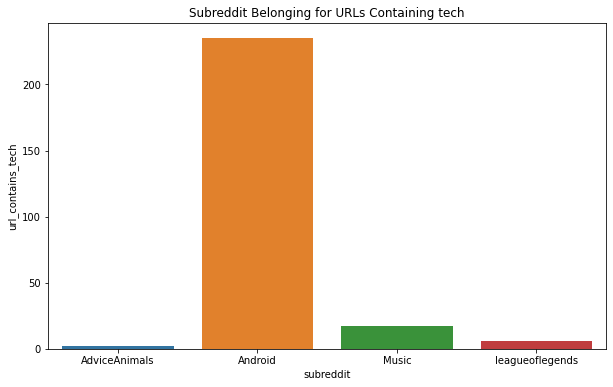

In [0]:
plot = data.groupby('subreddit')['url_contains_tech'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.title('Subreddit Belonging for URLs Containing tech')
sns.barplot(x="subreddit", y="url_contains_tech", data=plot)

## Part 3: Classification
- Train and test split is performed on the data, where 33% percent of the data will be used to test our model performance. Since our data is imbalanced, I've used stratification when doing train and test split.

In [0]:
X = data.drop(['score','subreddit','id','created_utc','selftext','url'],axis=1)
y = data['subreddit']

In [0]:
from sklearn.model_selection import train_test_split, GridSearchCV, \
                    cross_val_score, StratifiedKFold, RepeatedStratifiedKFold

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=46, stratify=y
    )

- The target variable which is subreddit is encoded, where 0 stands for AdviceAnimals, 1 stands for Android, 2 stands for Music and 3 stands for leagueoflegends.

In [0]:
from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

In [0]:
Encoder.inverse_transform([0, 1, 2, 3])

array(['AdviceAnimals', 'Android', 'Music', 'leagueoflegends'],
      dtype=object)

### Naive Bayes Classififier (with title as independent variable) 
- A Naive Bayes Classifier model is constructed using only title as independent variable and subreddit as dependent variable. Since title is a text column, I've performance CountVectorizer followed by TtidfTransformer on title to make it ready to input into the classification model.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import GridSearchCV
# Navie Bays Classifier - Baseline Model
# Reference code: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
text_clf = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                  ('clf', MultinomialNB())])
text_clf = text_clf.fit(X_train.title, y_train)

- The initial try of the default parameters of NB give an accuracy of 79% on the test dataset. However, since our data is imbalanced, it probably makes more sense to look at precision, recall and f1 score for each target class. 
- As an example for AdviceAnimals, what precision captures is that out of all the predictions of AdviceAnimals subreddit, what percentage does the model predict correctly. Recall on the other hand captures out of all real AdviceAnimals subreddit posts, what percentage does the model catch. F1 score is approximately the balanced score for precision and recall.
- From the intial classification report, the recall rates on AdviceAnimals and leagueoflegends are not so good. The model can capture signals correctly related to Android and Music, but fails at predicting the other two subreddits.

In [0]:
y_pred = text_clf.predict(X_test.title)
np.mean(y_pred == y_test)

0.7918908772368916

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.14      0.24      1158
           1       0.92      0.89      0.90      1616
           2       0.74      0.99      0.85      4373
           3       0.98      0.47      0.63       844

    accuracy                           0.79      7991
   macro avg       0.89      0.62      0.66      7991
weighted avg       0.83      0.79      0.75      7991



- After some parameter tuning, we can observe an obvious increase in model performance. Specifically instead of using one word gram, bigram can better predict subreddit of posts. Also, not using tdidf transformer increase the model performance. This maybe due to the reason that the transformer causes loss of information in the count vectors, especially for AdviceAnimals and leagueoflegends posts.
- The recall rates for AdviceAnimals and leagueoflegends have significantly increased, resulting in model performance increase. Although from the confusion matrix of the best NB model, we predicted 399 posts to be in Music but they are actually in AdviceAnimals. The model tends to predict a post to be in Music probably because it is the biggest class in our target.

In [0]:
# Reference code: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3)}

In [0]:
# Hyperparameter tunning - GridSearch
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train.title, y_train)

In [0]:
print(gs_clf.best_score_)
print(gs_clf.best_params_)

0.8730124311517862
{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}


In [0]:
y_pred = gs_clf.predict(X_test.title)
print(classification_report(y_test, y_pred))
df_nb = classification_report(y_test, y_pred, output_dict=True)
df_nb = pd.DataFrame(df_nb).transpose()

              precision    recall  f1-score   support

           0       0.81      0.55      0.65      1158
           1       0.90      0.93      0.91      1616
           2       0.88      0.96      0.92      4373
           3       0.90      0.80      0.85       844

    accuracy                           0.88      7991
   macro avg       0.87      0.81      0.83      7991
weighted avg       0.88      0.88      0.87      7991



In [0]:
def plot_confusion_matrix(y_true, y_pred, to_csv=True):
    """Plot confusion matrix."""
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    if to_csv:
        df = pd.DataFrame(conf_matrix)
    
    plt.figure(figsize=(10, 6))

    # Plot heatmap of confusion matrix
    sns.heatmap(
        conf_matrix,
        vmin=0,
        annot=True,
        fmt="d",
        xticklabels=["Predicted AdviceAnimals", "Predicted Android","Predicted Music","Predicted leagueoflegends"],
        yticklabels=["Actual AdviceAnimals", "Actual Android","Actual Music","Actual leagueoflegends"],
    )
    
    plt.title("population size = {}".format(len(y_pred)))
    plt.tight_layout()
    plt.show()

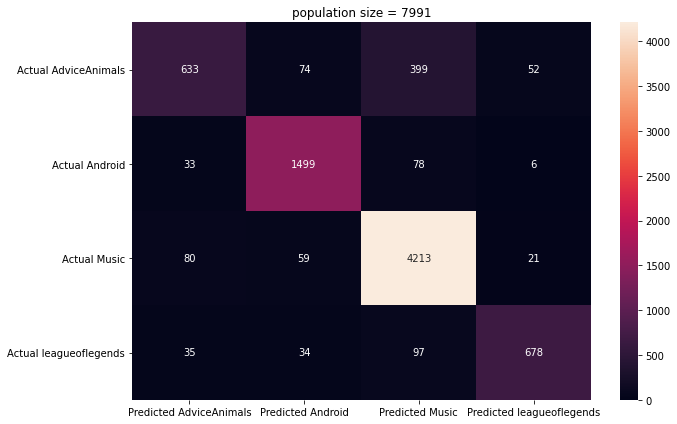

In [0]:
plot_confusion_matrix(y_test,y_pred)

### SGDC Classifier (with title as independent variable) 

- A SGDClassifier is used to train the data which is a linear classifer that by defualt in Sklearn uses SGD (stochastic gradient decent) techinuqe to find the minima. This estimator implements regularized linear models with SGD learning: the gradient of the loss is estimated each sample a time and the model is then updated along the way with the a decreasing strength schedule.
- The performance of the intial try of SGDC which is very similar to SVM is not as ideal as NB. However, after some parameter tuning, especially adjustment of the regularization of SGDClassifier.

In [0]:
# SCGDClassifer - Baseline Model
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                    ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, random_state=42))])
text_clf_svm = text_clf_svm.fit(X_train.title, y_train)
y_pred = text_clf_svm.predict(X_test.title)
np.mean(y_pred == y_test)

0.7363283694155925

In [0]:
# SCGDClassifer - Hyperparameter Tunning
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf-svm__alpha': (1e-2, 1e-3, 1e-4)}
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train.title, y_train)
print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

0.8765259272066104
{'clf-svm__alpha': 0.0001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


In [0]:
y_pred = gs_clf_svm.predict(X_test.title)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.56      0.66      1158
           1       0.93      0.92      0.92      1616
           2       0.87      0.96      0.92      4373
           3       0.90      0.78      0.84       844

    accuracy                           0.88      7991
   macro avg       0.87      0.81      0.83      7991
weighted avg       0.87      0.88      0.87      7991



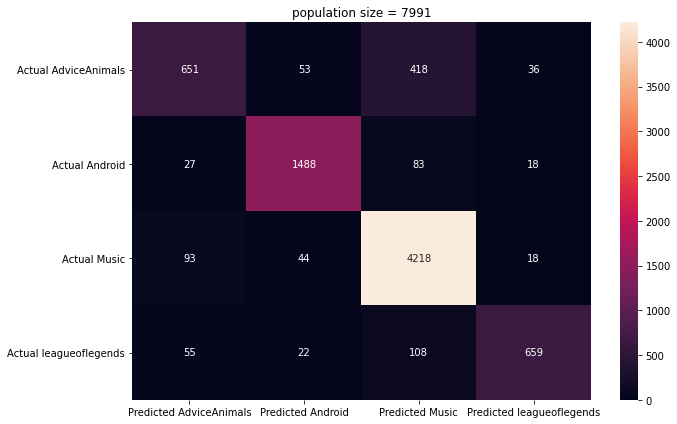

In [0]:
plot_confusion_matrix(y_test,y_pred)

In [0]:
print(classification_report(y_test, y_pred))
df_svm = classification_report(y_test, y_pred, output_dict=True)
df_svm = pd.DataFrame(df_svm).transpose()

              precision    recall  f1-score   support

           0       0.79      0.56      0.66      1158
           1       0.93      0.92      0.92      1616
           2       0.87      0.96      0.92      4373
           3       0.90      0.78      0.84       844

    accuracy                           0.88      7991
   macro avg       0.87      0.81      0.83      7991
weighted avg       0.87      0.88      0.87      7991



- In general, the results of NB and SGD is very similar with respect to accuracy, precision, recall and f1 score. And title solely is not ideal when classifying specificly for AdviceAnimals.

In [0]:
# Combine the above results into a table for comparisions
df_compare = pd.merge(df_nb,df_svm,left_index=True, right_index=True)
df_compare.columns = df_compare.columns.str.replace('_x','_nb')
df_compare.columns = df_compare.columns.str.replace('_y','_svm')
df_compare

,precision_nb,recall_nb,f1-score_nb,support_nb,precision_svm,recall_svm,f1-score_svm,support_svm
0,0.810499,0.546632,0.652914,1158.000000,0.788136,0.562176,0.656250,1158.000000
1,0.899760,0.927599,0.913467,1616.000000,0.925949,0.920792,0.923363,1616.000000
2,0.880092,0.963412,0.919869,4373.000000,0.873835,0.964555,0.916957,4373.000000
3,0.895641,0.803318,0.846971,844.000000,0.901505,0.780806,0.836825,844.000000
accuracy,0.878864,0.878864,0.878864,0.878864,0.877988,0.877988,0.877988,0.877988
macro avg,0.871498,0.810240,0.833305,7991.000000,0.872356,0.807082,0.833349,7991.000000
weighted avg,0.875627,0.878864,0.872190,7991.000000,0.874877,0.877988,0.872009,7991.000000


## Logistic Regression (with generated url, author and comments related independent variables)

#### Feature Engineering on author
- As indicated before, after train and test split, productive author indicators for each subreddit will be generated and applied to test dataset as well.

In [0]:
fe_train = X_train.copy()
fe_train['label'] = np.array(y_train) # generate a target named as label (same as subrredit)
len(fe_train['label'])

16222

In [0]:
fe_train = fe_train.reset_index(drop=True)

In [0]:
subreddit_author = fe_train.groupby(['author','label'])['title'].count().reset_index().\
                        rename(columns={'title':'subreddit_post_count'}).sort_values(by\
                        =['label','subreddit_post_count'],ascending=[False,False])
post_count = fe_train.groupby('author')['title'].count().reset_index().\
                        rename(columns={'title':'post_count'}).sort_values(by='post_count',ascending=False)
subreddit_author = pd.merge(subreddit_author,post_count,on='author',how='left')

In [0]:
# Filter the productive authors for each subrredit 
productive_author_leagueoflegends = subreddit_author[(subreddit_author['subreddit_post_count']>=5)\
                     &(subreddit_author['label']==3) \
                    &(subreddit_author['author']!='[deleted]')]['author'].to_list()
productive_author_music = subreddit_author[(subreddit_author['subreddit_post_count']>=5)\
                     &(subreddit_author['label']==2)\
                    &(subreddit_author['author']!='[deleted]')]['author'].to_list()
productive_author_android = subreddit_author[(subreddit_author['subreddit_post_count']>=5)\
                     &(subreddit_author['label']==1)\
                    &(subreddit_author['author']!='[deleted]')]['author'].to_list()
productive_author_adviceanimals = subreddit_author[(subreddit_author['subreddit_post_count']>=5)\
                     &(subreddit_author['label']==0)\
                    &(subreddit_author['author']!='[deleted]')]['author'].to_list()

In [0]:
# Training Dataset: Generate new features: "productive_author_(subrredit)" for each subrredit with binrary encoding of 0 and 1
fe_train['productive_author_leagueoflegends']=fe_train['author'].\
                        apply(lambda x: 1 if x in productive_author_leagueoflegends else 0)
fe_train['productive_author_music']=fe_train['author'].\
                        apply(lambda x: 1 if x in productive_author_music else 0)
fe_train['productive_author_android']=fe_train['author'].\
                        apply(lambda x: 1 if x in productive_author_android else 0)
fe_train['productive_author_adviceanimals']=fe_train['author'].\
                        apply(lambda x: 1 if x in productive_author_adviceanimals else 0)

In [0]:
X_train = fe_train.drop(['author','title','label'],axis=1)

In [0]:
# Testing Dataset: Generate new features: "productive_author_(subrredit)" for each subrredit with binrary encoding of 0 and 1
X_test['productive_author_leagueoflegends']=X_test['author'].\
                        apply(lambda x: 1 if x in productive_author_leagueoflegends else 0)
X_test['productive_author_music']=X_test['author'].\
                        apply(lambda x: 1 if x in productive_author_music else 0)
X_test['productive_author_android']=X_test['author'].\
                        apply(lambda x: 1 if x in productive_author_android else 0)
X_test['productive_author_adviceanimals']=X_test['author'].\
                        apply(lambda x: 1 if x in productive_author_adviceanimals else 0)

In [0]:
X_test = X_test.drop(['author','title'],axis=1)

- Using generated features from Author, URL and comments. Logistic regression gives as accuracy around 89%, which is better than using merely title as indicator variable. The recall and F1 score for AdviceAnimal class has seen increase, meaning that additional features can predict the AdviceAnimal subreddit better.

In [0]:
# Logistic Regression - Baseline Model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(
        penalty="none",
        solver="lbfgs",
        random_state=704
        )
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=704, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))
df_lr = classification_report(y_test, y_pred, output_dict=True)
df_lr = pd.DataFrame(df_lr).transpose()

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1158
           1       0.86      0.86      0.86      1616
           2       0.88      0.96      0.92      4373
           3       1.00      0.78      0.88       844

    accuracy                           0.89      7991
   macro avg       0.91      0.83      0.87      7991
weighted avg       0.89      0.89      0.89      7991



In [0]:
# Hyperparameter Tunning - GridSearch
param_grid = {'C': [0.01, 0.1, 1]}
gs_logreg = GridSearchCV(logreg, param_grid)
gs_logreg.fit(X_train, y_train)
print(gs_logreg.best_score_)
print(gs_logreg.best_params_)

0.889101434626733
{'C': 0.01}


In [0]:
y_pred = gs_logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1158
           1       0.86      0.86      0.86      1616
           2       0.88      0.96      0.92      4373
           3       1.00      0.78      0.88       844

    accuracy                           0.89      7991
   macro avg       0.91      0.83      0.87      7991
weighted avg       0.89      0.89      0.89      7991



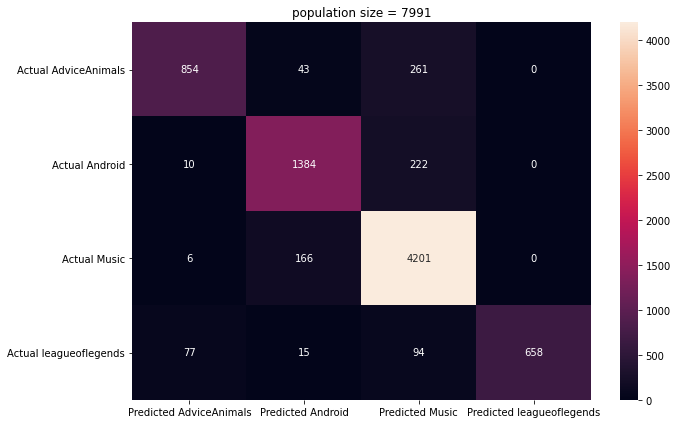

In [0]:
plot_confusion_matrix(y_test,y_pred)

In [0]:
def plot_feature_importance(feature_coef, to_csv=True):
    """Plot feature importance."""
    feat_names = [f[0] for f in feature_coef]
#     feat_names = [clean_name(fn) for fn in feat_names]
    feat_coef = [f[1] for f in feature_coef]

    if to_csv:
        df = pd.DataFrame(zip(feat_names, feat_coef), columns=["Name", "Importance"])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feat_coef, y=feat_names)
    plt.title("Feature Coefficient")
    plt.tight_layout()
    plt.show()

- From the logistic regression coefficients, what can be learned is that URL is a strong predictor for subreddit.URL contains JPG that provides a lot more information for classification for AdviceAnimals subreddit. Thus increasing the model performance compared to NB and SGDC using only title as the predictor.

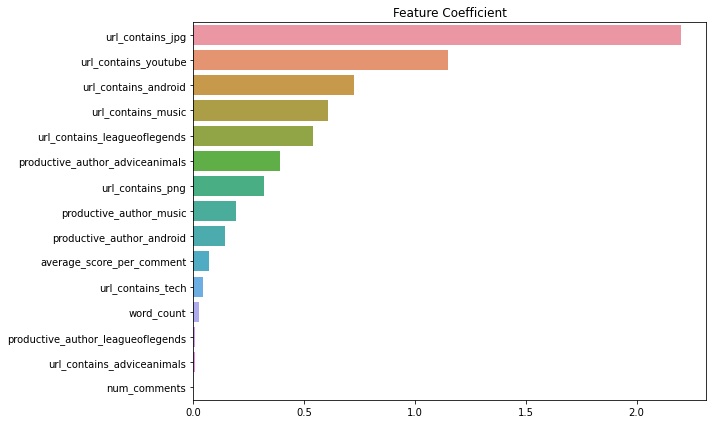

In [0]:
coef_abs = [abs(coef) for coef in logreg.coef_[0]]
feature_coef = zip(\
            X_train.columns,\
            coef_abs,\
        )
feature_coef_sorted = sorted(feature_coef, key=(lambda x: x[1]), reverse=True)

plot_feature_importance(feature_coef_sorted)

## XGBOOST (generated features from author and url, comments as independent variables)

- XGBoost (extrene Gradient Boosting) bascially implements the gradient boosting decision tree algorithm. This Classifier is used for this porject because of its fast execution speed and great model performance.
- XGBoost performs really well on subreddit classification compared to other models I tried. This could indicate that trees can better classify our data, learning from the errors from the previous tree (edge cases increases the classification accuracy)

In [0]:
#XGBoost Classifer
from xgboost import XGBClassifier, plot_importance
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))
df_xgb = classification_report(y_test, y_pred, output_dict=True)
df_xgb = pd.DataFrame(df_xgb).transpose()

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1158
           1       0.93      0.90      0.91      1616
           2       0.95      0.99      0.97      4373
           3       0.99      0.84      0.91       844

    accuracy                           0.94      7991
   macro avg       0.94      0.90      0.92      7991
weighted avg       0.94      0.94      0.94      7991



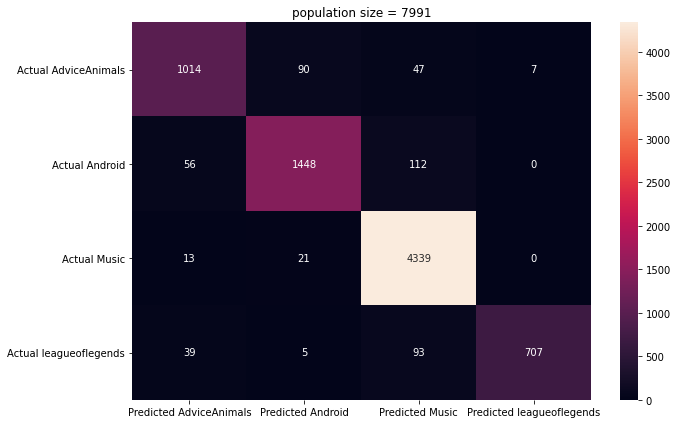

In [0]:
plot_confusion_matrix(y_test,y_pred)

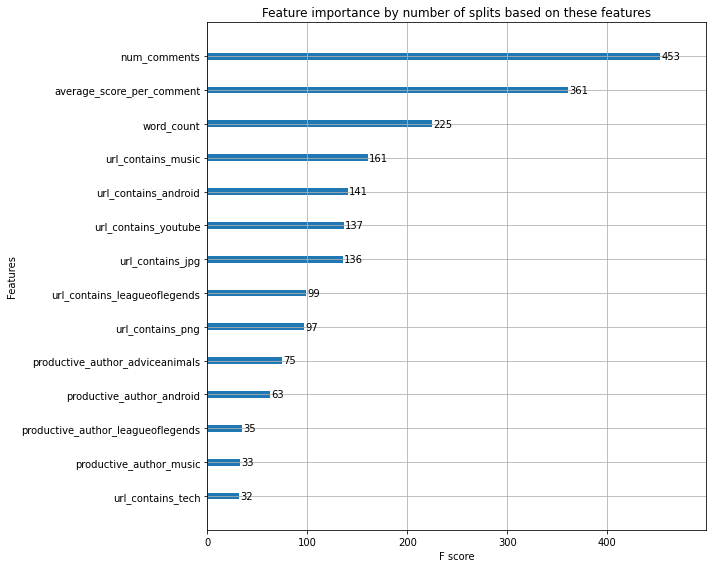

<Figure size 432x288 with 0 Axes>

In [0]:
# Reference source: https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
# Plot the feature importance for the model
# The default importance measure is weight which is the number of times a feature is used to split the data across all trees
ax = plot_importance(xgb)
fig = ax.figure
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.title('Feature importance by number of splits based on these features')
plt.show()
plt.clf()

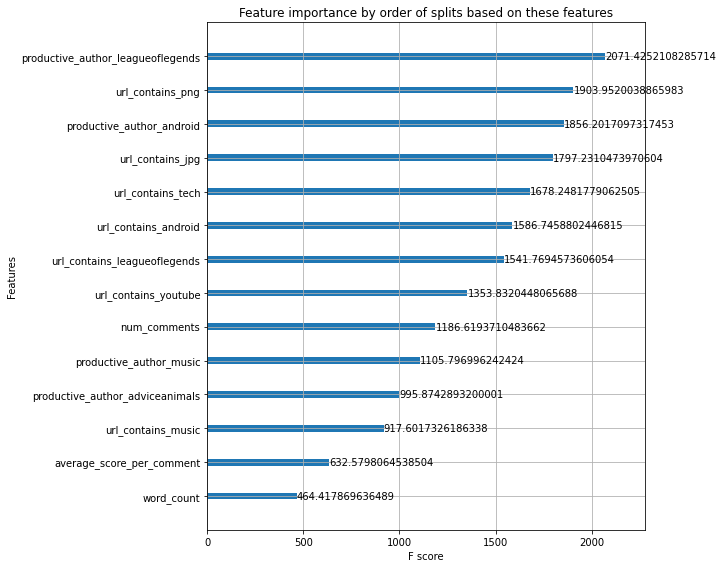

<Figure size 432x288 with 0 Axes>

In [0]:
# Plot the feature importance by cover
# Cover: The number of times a feature is used to split the data across all trees weighted by the number of training data points that go thourgh those splits.
ax = plot_importance(xgb, importance_type='cover')
fig = ax.figure
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.title('Feature importance by order of splits based on these features')
plt.show()
plt.clf()

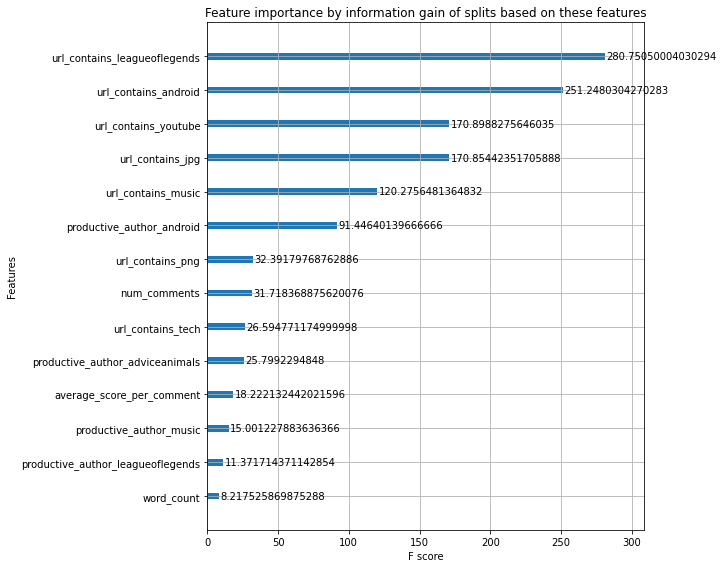

<Figure size 432x288 with 0 Axes>

In [0]:
 # Plot the feature importance by gain:
 # Gain: The average training loss reduction gained when using a feature for spliting
 ax = plot_importance(xgb, importance_type='gain')
fig = ax.figure
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.title('Feature importance by information gain of splits based on these features')
plt.show()
plt.clf()

# Comparison of 4 models: Logistic regression, Naive Bayes, SVDC, XGB
- Naive Bayes and SVDC only use title as predictors. For these two models, they have poor predictions for AdviceAnimals and League of legends subreddits, which maybe because information contained in title is not precise enough.
Logistic Regression and XGBoost on the hand, using other predictors like URL, comments as predictors.These models have better performance because they provide more information on adviceanimals and League of Legends subreddits. 
XGBoost, above all has a best performance because of its strong predictive power. 
What can be further tried could be different algorithms like ensembling trees and random forests.
- Also, from the df_compare summary below, using f1 score, precision and recall as measurements, it shows that XGBoost has almost highest f1-score, precision and recall among all 4 models. Therefore, XGBoost is the best model.

In [0]:
# Combine all the models and inspect the difference to seek for the best one
df_compare = pd.merge(df_nb, df_svm,left_index=True, right_index=True)
df_compare.columns = df_compare.columns.str.replace('_x','_nb')
df_compare.columns = df_compare.columns.str.replace('_y','_svm')
df_compare = pd.merge(df_compare,df_lr,left_index=True, right_index=True)
df_compare = pd.merge(df_compare,df_xgb,left_index=True, right_index=True)
df_compare.columns = df_compare.columns.str.replace('_x','_lr')
df_compare.columns = df_compare.columns.str.replace('_y','_xgb')
# df_compare['precision_gains'] = (df_compare['precision_xgb']-df_compare['precision_lr'])/df_compare['precision_lr']
# df_compare['recall_gains'] = (df_compare['recall_xgb']-df_compare['recall_lr'])/df_compare['recall_lr']
# df_compare['f1-score_gains'] = (df_compare['f1-score_xgb']-df_compare['f1-score_lr'])/df_compare['f1-score_lr']

In [0]:
df_compare=df_compare.reindex(sorted(df_compare.columns), axis=1)
df_compare=df_compare.drop(index=['macro avg','weighted avg'])

In [0]:
df_compare

,f1-score_lr,f1-score_nb,f1-score_svm,f1-score_xgb,precision_lr,precision_nb,precision_svm,precision_xgb,recall_lr,recall_nb,recall_svm,recall_xgb,support_lr,support_nb,support_svm,support_xgb
0,0.811401,0.652914,0.656250,0.889474,0.901795,0.810499,0.788136,0.903743,0.737478,0.546632,0.562176,0.875648,1158.000000,1158.000000,1158.000000,1158.000000
1,0.858561,0.913467,0.923363,0.910692,0.860697,0.899760,0.925949,0.925831,0.856436,0.927599,0.920792,0.896040,1616.000000,1616.000000,1616.000000,1616.000000
2,0.918151,0.919869,0.916957,0.968095,0.879238,0.880092,0.873835,0.945110,0.960668,0.963412,0.964555,0.992225,4373.000000,4373.000000,4373.000000,4373.000000
3,0.876165,0.846971,0.836825,0.907574,1.000000,0.895641,0.901505,0.990196,0.779621,0.803318,0.780806,0.837678,844.000000,844.000000,844.000000,844.000000
accuracy,0.888124,0.878864,0.877988,0.939557,0.888124,0.878864,0.877988,0.939557,0.888124,0.878864,0.877988,0.939557,0.888124,0.878864,0.877988,0.939557


- However, in our case of learning imbalanced data, the majority classes might be of our great interest. It is desirable to have a classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy for the minority classes. Therefore, we will leave it as it is.

## Part 4: Sentiment Analysis

Using Vader to compute for each post the sentiment of title field.
- The Positive, Negative and Neutral scores represent the proportion of posts that falls in these categories

- The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive). 

In [0]:
title = []
compound = []
positive = []
neutral = []
negative = []

In [0]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [0]:
def nltk_sentiment(sentence):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

In [0]:
nltk_results = [nltk_sentiment(row) for row in data['title']]
results_df = pd.DataFrame(nltk_results)
data = data.reset_index()
text_df = pd.DataFrame(data['title'])
nltk_df = data.join(results_df)

In [0]:
data = data.join(results_df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8bafaf8ef0>,
      dtype=object)

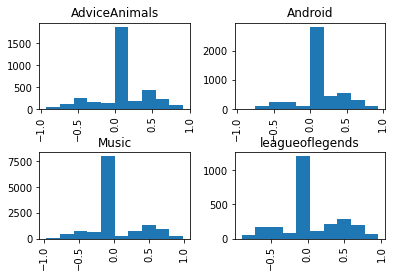

In [0]:
data['compound'].hist(by=data['subreddit'])

In [0]:
data['compound'].groupby(data['subreddit']).describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
AdviceAnimals,3507.0,0.047272,0.331203,-0.9313,0.0,0.0,0.2263,0.9097
Android,4897.0,0.082763,0.297302,-0.9413,0.0,0.0,0.2960,0.9335
Music,13251.0,0.063277,0.321242,-0.9705,0.0,0.0,0.1531,0.9831
leagueoflegends,2558.0,0.071692,0.370957,-0.8934,0.0,0.0,0.3612,0.9571


### Learnings from the results
- All subreddits have the neutral sentiment most frequently, followed by positive sentiment;
- League of legends has more posts with positive sentiment;
- Mean values of sentiment score show no siginificant difference, while Android is comparatively more associated with positive sentiment.

In [0]:
data['compound'][data['subreddit'] == 'AdviceAnimals'].mean()

0.047271884801824864

### definition of threshold for each subreddit: 
- Initial thresholds are -0.3 and 0.3 
- To leverage different mean values of subreddits, consider the mean value to be central of neutral sentiment
- Positive if score >= 0.3 + mean sentiment score of each subreddit
- Negative if score < -0.3 + mean sentiment score of each subreddit

Accordingly, adding labels 'is_pos' and 'is_neg' as indicator of positive and negative sentiment

In [0]:
# Advice Animals and Android
threshold = 0.3

data.loc[(data['compound']>=data['compound'][data['subreddit'] == data['subreddit']].mean() + threshold), 'is_pos'] = 1
data.loc[(data['compound']<data['compound'][data['subreddit'] == data['subreddit']].mean() + threshold), 'is_pos'] = 0

data.loc[(data['compound']<=data['compound'][data['subreddit'] == data['subreddit']].mean() - threshold), 'is_neg'] = 1
data.loc[(data['compound']>data['compound'][data['subreddit'] == data['subreddit']].mean() - threshold), 'is_neg'] = 0


Removing posts that are not clearly negative or positive.

In [0]:
indexNames = data[(data['is_pos'] == 0) & (data['is_neg'] == 0)].index
data.drop(indexNames , inplace=True)

In [0]:
data['is_pos'].groupby(data['subreddit']).value_counts()

subreddit        is_pos
AdviceAnimals    1.0       683 
                 0.0       544 
Android          1.0       961 
                 0.0       538 
Music            1.0       2560
                 0.0       1701
leagueoflegends  1.0       614 
                 0.0       445 
Name: is_pos, dtype: int64

Percentage of Positive and Negative sentiment after removing posts with neutral sentiment. 
When is_pos = 0, it means this post has negative sentiment.

In [0]:
pd.crosstab(data['subreddit'], data['is_pos']).apply(lambda r: r/r.sum(), axis=1)

is_pos,0.0,1.0
subreddit,,
AdviceAnimals,0.443358,0.556642
Android,0.358906,0.641094
Music,0.399202,0.600798
leagueoflegends,0.420208,0.579792


Find top 10 words in posts with positive and negative sentiment separately.

**Positive Titles**

In [0]:
# Single word
a = data[data['is_pos'] == 1]

common_words = [get_top_n_words(a[a['subreddit']=='AdviceAnimals']['title'], 10),
                get_top_n_words(a[a['subreddit']=='Music']['title'], 10),
                get_top_n_words(a[a['subreddit']=='Android']['title'], 10),
                get_top_n_words(a[a['subreddit']=='leagueoflegends']['title'], 10)]

subrredit_list =['AdviceAnimals','Music','Android','leagueoflegends']
count = 0
for i in common_words:
    df2 = pd.DataFrame(i, columns = ['title' , 'count'])
    print('Subreddit: ',subrredit_list[count])
    print(df2.groupby('title').sum()['count'].sort_values(ascending=False),'\n')
    count += 1
    

Subreddit:  AdviceAnimals
title
good      45
best      41
help      32
like      30
dog       28
people    27
make      25
friend    25
love      23
free      22
Name: count, dtype: int64 

Subreddit:  Music
title
music       396
love        333
rock        330
song        329
help        186
best        182
songs       176
pop         175
playlist    154
good        154
Name: count, dtype: int64 

Subreddit:  Android
title
android    279
best       170
help       143
app        117
phone      116
google     108
free       97 
apps       80 
good       62 
2019       60 
Name: count, dtype: int64 

Subreddit:  leagueoflegends
title
champion     76
new          54
support      41
lol          41
league       38
game         38
play         36
best         33
champions    30
season       28
Name: count, dtype: int64 



In [0]:
# Bi-words (double confrim with the single word output)
# Note the analysis is mainly based on the single word as the frequency of the bi-words in each subreddit is quit low and less representative
def get_top_n_words_v2(corpus, num,n=None):
    vec = CountVectorizer(ngram_range=(num, num),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
a = data[data['is_pos'] == 1]

common_words = [get_top_n_words_v2(a[a['subreddit']=='AdviceAnimals']['title'], 2,10),
                get_top_n_words_v2(a[a['subreddit']=='Music']['title'], 2,10),
                get_top_n_words_v2(a[a['subreddit']=='Android']['title'], 2,10),
                get_top_n_words_v2(a[a['subreddit']=='leagueoflegends']['title'], 2,10)]

subrredit_list =['AdviceAnimals','Music','Android','leagueoflegends']
count = 0
for i in common_words:
    df2 = pd.DataFrame(i, columns = ['title' , 'count'])
    print('Subreddit: ',subrredit_list[count])
    print(df2.groupby('title').sum()['count'].sort_values(ascending=False),'\n')
    count += 1
    

Subreddit:  AdviceAnimals
title
loves baby           7
dog loves            7
new year             5
right tools          4
feels good           4
baby compilation     4
vegas pro            3
sony vegas           3
blender templates    3
best blender         3
Name: count, dtype: int64 

Subreddit:  Music
title
hip hop             89
music video         46
need help           42
help finding        38
indie rock          30
alternative rock    29
new wave            21
pop rock            18
finding song        18
love song           17
Name: count, dtype: int64 

Subreddit:  Android
title
need help           25
best android        25
android phone       24
view 20             21
honor view          19
apps android        17
app android         17
android apps        16
google assistant    14
free download       13
Name: count, dtype: int64 

Subreddit:  leagueoflegends
title
league legends         18
honor level            8 
champ select           7 
new champion           6 
unshac

**Negative Titles**

In [0]:
# Single words
a = data[data['is_neg'] == 1]

common_words = [get_top_n_words(a[a['subreddit']=='AdviceAnimals']['title'], 10),
                get_top_n_words(a[a['subreddit']=='Music']['title'], 10),
                get_top_n_words(a[a['subreddit']=='Android']['title'], 10),
                get_top_n_words(a[a['subreddit']=='leagueoflegends']['title'], 10)]
subrredit_list =['AdviceAnimals','Music','Android','leagueoflegends']
count = 0
for i in common_words:
    df2 = pd.DataFrame(i, columns = ['title' , 'count'])
    print('Subreddit: ',subrredit_list[count])
    print(df2.groupby('title').sum()['count'].sort_values(ascending=False),'\n')
    count += 1

Subreddit:  AdviceAnimals
title
people     27
shit       21
bad        21
scumbag    17
hate       17
dog        16
time       15
fuck       15
wrong      14
know       13
Name: count, dtype: int64 

Subreddit:  Music
title
rock           324
pop            119
metal          100
music          99 
new            93 
alternative    93 
song           91 
hip            89 
indie          84 
hop            84 
Name: count, dtype: int64 

Subreddit:  Android
title
android    127
google     78 
phone      68 
samsung    37 
app        34 
huawei     33 
galaxy     30 
problem    29 
apps       26 
phones     25 
Name: count, dtype: int64 

Subreddit:  leagueoflegends
title
riot      89
game      44
bad       24
new       20
team      19
ranked    18
league    18
damage    18
broken    18
banned    18
Name: count, dtype: int64 



In [0]:
# Bi-words
# Note the analysis is mainly based on the single word as the frequency of the bi-words in each subreddit is quit low and less representative
a = data[data['is_neg'] == 1]

common_words = [get_top_n_words_v2(a[a['subreddit']=='AdviceAnimals']['title'], 2,10),
                get_top_n_words_v2(a[a['subreddit']=='Music']['title'], 2,10),
                get_top_n_words_v2(a[a['subreddit']=='Android']['title'], 2,10),
                get_top_n_words_v2(a[a['subreddit']=='leagueoflegends']['title'], 2,10)]

subrredit_list =['AdviceAnimals','Music','Android','leagueoflegends']
count = 0
for i in common_words:
    df2 = pd.DataFrame(i, columns = ['title' , 'count'])
    print('Subreddit: ',subrredit_list[count])
    print(df2.groupby('title').sum()['count'].sort_values(ascending=False),'\n')
    count += 1
    

Subreddit:  AdviceAnimals
title
star wars              5
vicious cycle          3
substantiate claims    3
rapists showed         3
police claim           3
feel bad               3
claims rapists         3
seventh circle         2
crab legs              2
circle hell            2
Name: count, dtype: int64 

Subreddit:  Music
title
hip hop             82
alternative rock    42
indie rock          26
death metal         26
chris brown         24
new wave            22
music video         21
post hardcore       18
punk rock           17
indie pop           15
Name: count, dtype: int64 

Subreddit:  Android
title
galaxy s10          13
samsung galaxy      11
android phone       9 
android pie         8 
android gameplay    7 
hole punch          6 
google pixel        6 
pixel xl            5 
anti google         5 
android phones      5 
Name: count, dtype: int64 

Subreddit:  leagueoflegends
title
riot games        9
lee sin           9
nexus blitz       4
league legends    4
enemy team

### Analyze the results: subreddit-specific patterns
- For animal advice, some frequents positive words are help, friend, love, free which are advice for better protecting animals. On the other hand, the negative words show that people may not like the waste from animals.
- For music, some themes like rock and pop are quite controversial with both positive and negative reviews, while metal and new songs are more likely to have bad reviews.
- For android, brands like samsung and huawei convey negative sentiment more frequently.
- For League of Legends, champion is more positive while words like riot are more related to negative sentiment


### Explain the method/metric in analysis: 
This sentiment analysis first predict sentiment into scores, then categorizing into positive and negative if applied and removing other data. By Finding top words (single and bi-words) in each subreddit, there are different patterns in different subreddits.

#### Reference:
https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a
https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f
https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a